In [326]:
import sys
import os

sys.path.append("..")

In [328]:
import pandas as pd
pd.set_option('max_columns', None)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.compose import ColumnTransformer

from xgboost import XGBClassifier

from utils import evaluate_model, plot_curve

In [329]:
data = pd.read_csv("../data/raw/Chapter_3_Diabetes_data.csv", low_memory=False)
data.shape

(101768, 50)

### Data exploration

In [330]:
data.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,NaN,NaN,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [331]:
data.shape[0], data["encounter_id"].nunique(), data["patient_nbr"].nunique()

(101768, 101766, 71518)

Looks like there are 2 potential duplicated rows, let's remove them

In [332]:
data.drop_duplicates(inplace=True)

In [333]:
missing = data.isnull().sum()
print("% of missing data")
missing[missing!=0] / len(data) * 100

% of missing data


race                  2.233555
weight               96.858479
payer_code           39.557416
medical_specialty    49.082208
diag_1                0.020636
diag_2                0.351787
diag_3                1.398306
dtype: float64

In [334]:
data["race"].value_counts()

Caucasian          76099
AfricanAmerican    19210
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [335]:
print(f'medical_specialty has {data["medical_specialty"].nunique()} unique values \n Top 20:')
data["medical_specialty"].value_counts().head(20)

medical_specialty has 72 unique values 
 Top 20:


InternalMedicine                     14635
Emergency/Trauma                      7565
Family/GeneralPractice                7440
Cardiology                            5352
Surgery-General                       3099
Nephrology                            1613
Orthopedics                           1400
Orthopedics-Reconstructive            1233
Radiologist                           1140
Pulmonology                            871
Psychiatry                             854
Urology                                685
ObstetricsandGynecology                671
Surgery-Cardiovascular/Thoracic        652
Gastroenterology                       564
Surgery-Vascular                       533
Surgery-Neuro                          468
PhysicalMedicineandRehabilitation      391
Oncology                               348
Pediatrics                             254
Name: medical_specialty, dtype: int64

In [336]:
print(f'payer_code has {data["payer_code"].nunique()} unique values')
data["payer_code"].value_counts()

payer_code has 17 unique values


MC    32439
HM     6274
SP     5007
BC     4655
MD     3532
CP     2533
UN     2448
CM     1937
OG     1033
PO      592
DM      549
CH      146
WC      135
OT       95
MP       79
SI       55
FR        1
Name: payer_code, dtype: int64

In [337]:
data["race"] = data["race"].fillna("Other")
data["medical_specialty"] = data["medical_specialty"].fillna("NA")
data["payer_code"] = data["payer_code"].fillna("NA")

Age is encoded in ranges, but it makes sense to convert it to numerical

In [338]:
age_mapping = {
    "[0-10)":10,
    "[10-20)":20,   
    "[20-30)":30,   
    "[30-40)":40,   
    "[40-50)":50,   
    "[50-60)":60,   
    "[60-70)":70,   
    "[70-80)":80,   
    "[80-90)":90,   
    "[90-100)":100
}
data["age"] = data["age"].replace(age_mapping)

Some numbers in data are actually categories, let's convert them

In [339]:
categorical = [
    "encounter_id",
    "patient_nbr",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id"
]
for variable in categorical:
    data[variable] = pd.Categorical(data[variable])

In [340]:
data.describe(include=["category"])

,encounter_id,patient_nbr,admission_type_id,discharge_disposition_id,admission_source_id
count,101766,101766,101766,101766,101766
unique,101766,71518,8,26,17
top,443867222,88785891,1,1,7
freq,1,40,53990,60234,57494


In [341]:
data.describe(include=["object"])

,race,gender,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,3197,101766,101766,101745,101408,100343,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,5,3,9,18,73,716,748,789,4,4,4,4,4,4,4,2,4,4,2,4,4,4,4,2,3,1,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[75-100),NA,NA,428,276,250,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,1336,40256,49949,6862,6752,11555,96420,84748,81778,100227,101063,101680,96575,101765,89080,91116,101743,94438,95401,101458,101728,101763,101727,101766,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


In [342]:
def plot_bar(column: str, sort_index=False, rot=None) -> None:
    values = data[column].value_counts()
    if sort_index:
        values.sort_index().plot.bar(title=column, rot=rot)
    else: 
        values.plot.bar(title=column, rot=rot)

Let's see distributions of medications related variables

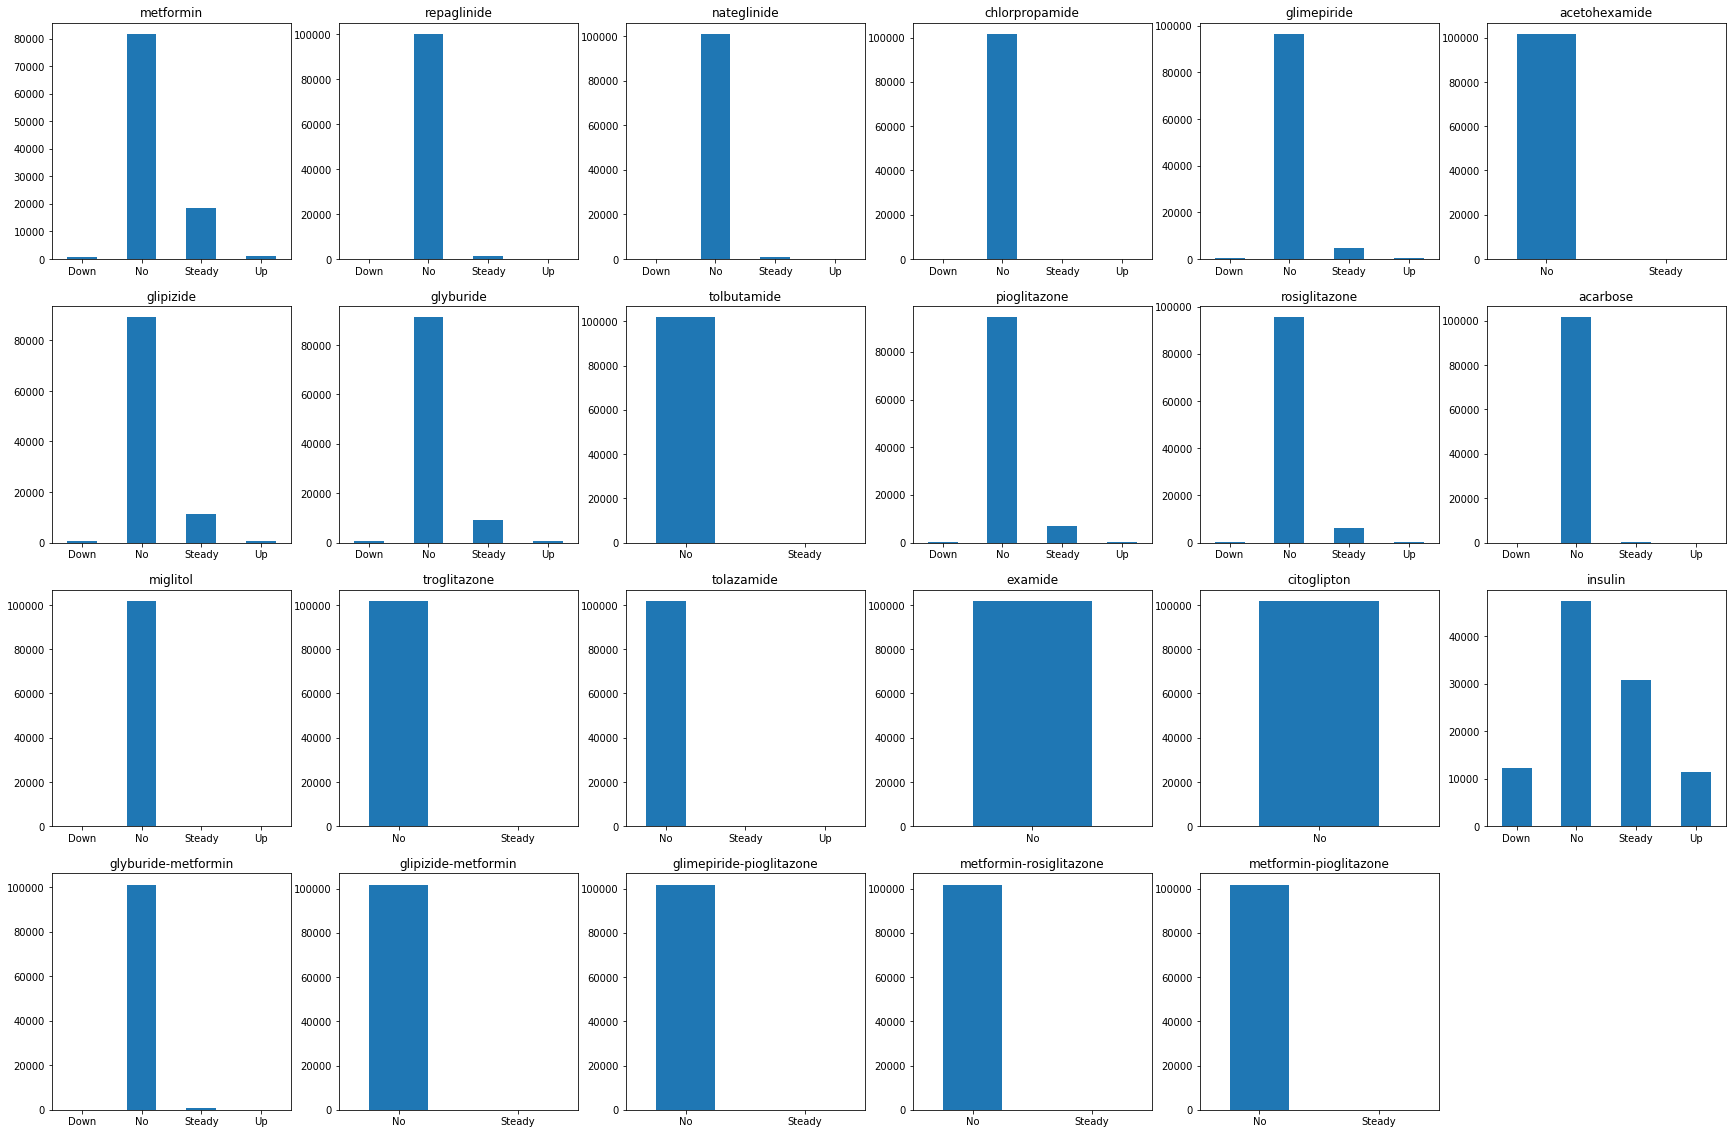

In [343]:
medicine = data.loc[:, "metformin":"metformin-pioglitazone"].columns

plt.figure(figsize=(30, 20))
for ix, column in enumerate(medicine):
    plt.subplot(4, 6, ix + 1)
    plot_bar(column, sort_index=True, rot=0)

Most medications have very low variation with **examide**, **citoglipton** having only 1 unique value, so we can drop them before training

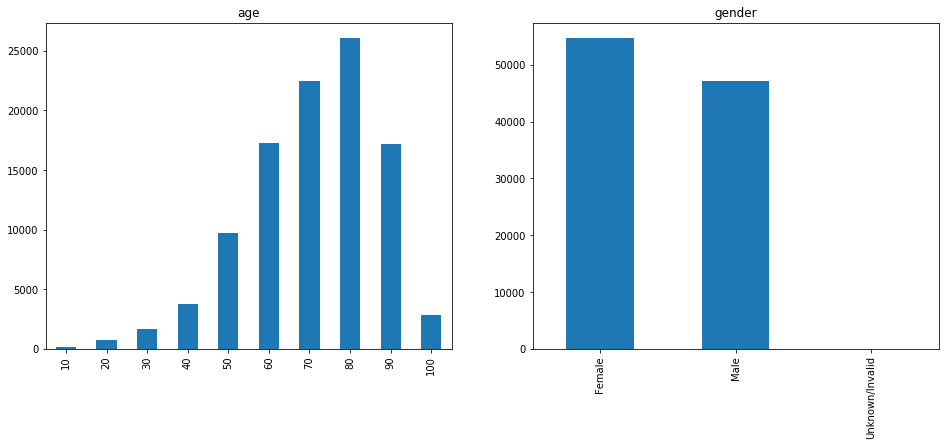

In [344]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_bar("age", sort_index=True)
plt.subplot(1, 2, 2)
plot_bar("gender")

Some patients seems to appear in dataset more that once. It may be useful to use it as additional feature

In [345]:
rows_per_patient = data.groupby('patient_nbr')["encounter_id"].count()
data = data.merge(rows_per_patient, on='patient_nbr', suffixes=("", "_count"))
data["running_count"] = data.groupby("patient_nbr").cumcount()

In [346]:
data[data["encounter_id_count"] > 1].head(10)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,encounter_id_count,running_count
12,40926,85504905,Caucasian,Female,50,NaN,1,3,7,7,NA,Family/GeneralPractice,60,0,15,0,1,0,428,250.43,250.6,8,None,None,Steady,Up,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,<30,2,0
13,76387002,85504905,Caucasian,Female,50,NaN,1,6,7,9,NA,InfectiousDiseases,46,1,14,0,0,0,730,250.81,707,9,None,Norm,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,2,1
28,248916,115196778,Caucasian,Female,60,NaN,1,1,1,2,NA,Surgery-General,25,2,11,0,0,0,996,585,250.01,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,5,0
29,6068238,115196778,Caucasian,Female,60,NaN,1,3,7,5,NA,Family/GeneralPractice,44,1,16,0,0,3,427,585,250.41,8,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,5,1
30,33695262,115196778,Caucasian,Female,70,NaN,1,1,7,7,NA,Surgery-General,45,4,21,0,0,15,996,38,403,8,None,>7,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,<30,5,2
31,45573132,115196778,Caucasian,Female,70,NaN,1,1,7,2,NA,Surgery-General,31,2,13,0,0,14,996,403,413,7,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30,5,3
32,77757156,115196778,Caucasian,Female,70,NaN,1,1,7,7,NA,Pulmonology,47,1,20,0,0,2,493,403,786,6,None,None,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,>30,5,4
33,250872,41606064,Caucasian,Male,30,NaN,2,1,2,10,NA,NA,53,0,20,0,0,0,277,250.02,263,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Down,No,No,No,No,No,Ch,Yes,>30,3,0
34,2309376,41606064,Caucasian,Male,30,NaN,2,1,2,2,NA,NA,35,0,12,0,0,1,277,250.02,753,3,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,3,1
35,11198010,41606064,Caucasian,Male,30,NaN,2,1,2,9,NA,NA,36,0,18,1,0,3,277,250.02,753,6,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30,3,2


### Basic modelling

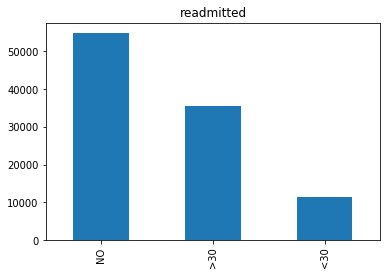

In [347]:
plot_bar("readmitted")

We will be predicting whether the patient will be readmitted to the hospital within 30 days

In [348]:
data["target"] = data["readmitted"] == "<30"

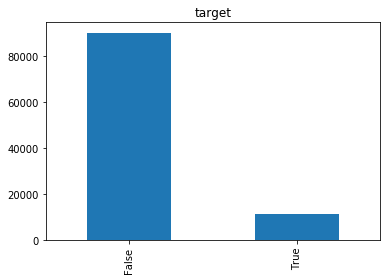

In [349]:
plot_bar("target")

In [350]:
data.set_index("encounter_id", inplace=True)

In [351]:
not_train_columns = [
           "patient_nbr", 
           "payer_code", 
           "medical_specialty",
           "weight",
           "diag_1",
           "diag_2",
           "diag_3",
           "change",
           "examide", 
           "citoglipton", 
           "diabetesMed",
           "readmitted",
           "running_count",
           "encounter_id_count",
           "target"]

Assuming that **encounter_id** represents natural order we need to create out train-validation split accordingly

In [352]:
data = data.sort_values(by="encounter_id")

In [353]:
x_train, x_test, y_train, y_test = train_test_split(
    data.drop(not_train_columns, axis=1),
    data["target"],
    shuffle=False,
    test_size=0.20)

In [354]:
cat = [t != "int64" for t in x_train.dtypes]
num = [t == "int64" for t in x_train.dtypes]

cat_names = x_train.columns[cat]
num_names = x_train.columns[num]


transformer = ColumnTransformer(
    [("num", Normalizer(), num),
    ("cat",  OneHotEncoder(handle_unknown="ignore"), cat)],
)

x_train = transformer.fit_transform(x_train)
x_test = transformer.transform(x_test)


cat_names = transformer.transformers_[1][1].get_feature_names(cat_names)

all_feature_names = list(num_names)
all_feature_names.extend(cat_names)

In [355]:
clf = LogisticRegression(random_state=42, solver="liblinear")
clf.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [356]:
evaluate_model(y_test, clf.predict_proba(x_test)[:, 1])

{'accuracy': 0.8934853100127739,
 'auc': 0.6509867149791244,
 'precision': 0.4915254237288136,
 'recall': 0.01338255652976465}

In [290]:
clf2 = RandomForestClassifier(n_estimators=10)

In [291]:
clf2.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [310]:
evaluate_model(y_test, clf2.predict_proba(x_test)[:, 1])

{'accuracy': 0.8908813992335659,
 'auc': 0.5756240816544951,
 'precision': 0.28225806451612906,
 'recall': 0.016151361329026302}

In [293]:
clf3 = XGBClassifier()

In [294]:
clf3.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [320]:
evaluate_model(y_test, clf3.predict_proba(x_test)[:, 1])

{'accuracy': 0.8934361796207134,
 'auc': 0.6581021236358805,
 'precision': 0.4583333333333333,
 'recall': 0.005076142131979695}

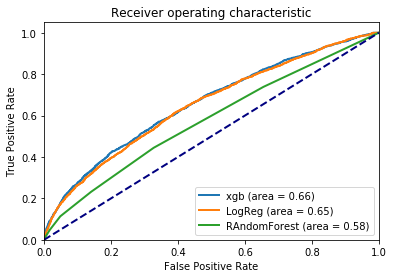

In [357]:
plot_curve(y_test, xgb = clf3.predict_proba(x_test)[:, 1], 
                   LogReg=clf.predict_proba(x_test)[:, 1],
                   RAndomForest=clf2.predict_proba(x_test)[:, 1])